## Import libraries, methods and constants

In [1]:
import numpy as np
import torch
import os
from os import sys

In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data_prepossessing import create_datasets_for_plants, get_labels
from data_visualization import plot_ground_truth_annotation
from constants import weed_plants, weed_plants
from config import checkpoint
from data_visualization import plot_predicted_segm_mask, plot_original_image
from transformers import AutoModelForSemanticSegmentation

c:\ProgramData\miniconda3\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check if GPU is detected

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


## Predict and visualize new instances

In [4]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\ProgramData\miniconda3\envs\master\Lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [5]:
def get_test_data(crop, model_type):
    model_plant_names = [crop] + weed_plants
    train_ds, test_ds = create_datasets_for_plants(model_plant_names, model_type, crop)

    return test_ds

In [6]:
def get_model(crop, model_type):
    id2label, label2id = get_labels(crop, model_type)

    models_folder = '../models-3-patience/'
    checkpoint = models_folder + model_type + '/' + crop + '/'
    model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
    model.to(device)

    return model

In [7]:
def pred_segm_mask(image, image_processor, device, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)

    outputs = model(pixel_values=pixel_values)

    logits = outputs.logits.cpu()

    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    return upsampled_logits.argmax(dim=1)[0]

In [8]:
def plot_all_info_for_image(test_ds_entry, binary_model, multiclass_model):
    binary_pred_seg = pred_segm_mask(test_ds_entry["image"], image_processor, device, binary_model)
    multiclass_pred_seg = pred_segm_mask(test_ds_entry["image"], image_processor, device, multiclass_model)

    plot_predicted_segm_mask(binary_pred_seg, test_ds_entry["image_name"], "binary")
    plot_predicted_segm_mask(multiclass_pred_seg, test_ds_entry["image_name"], "multiclass")
    plot_ground_truth_annotation(test_ds_entry["image_name"])
    plot_original_image(test_ds_entry["image_name"])

#### Visualize predicted segmentation masks for soybean models

In [9]:
soybean_test_ds = get_test_data('soybean', 'binary')
soybean_binary_model = get_model('soybean', 'binary')
soybean_multiclass_model = get_model('soybean', 'multiclass')

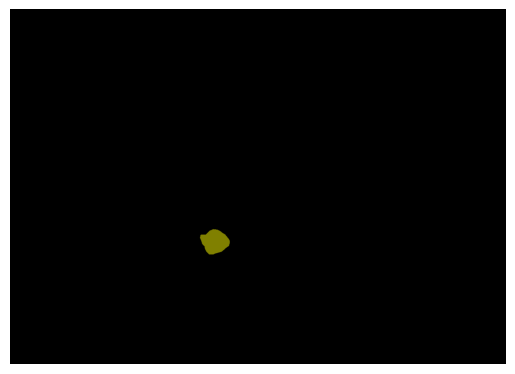

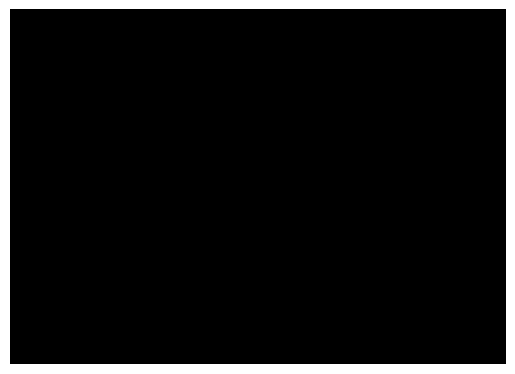

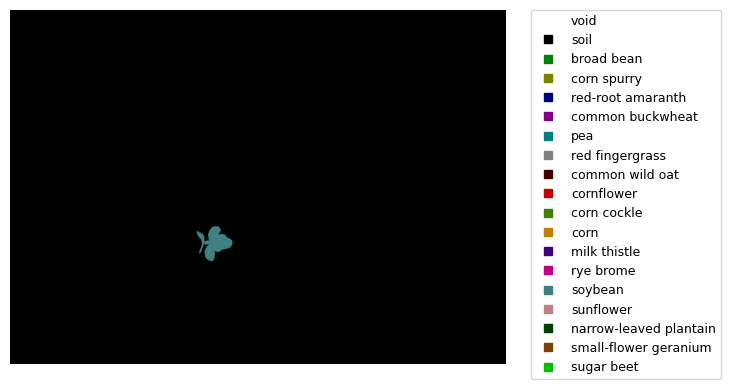

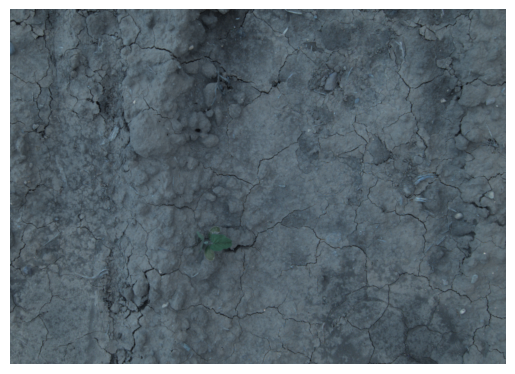

In [10]:
plot_all_info_for_image(soybean_test_ds[0], soybean_binary_model, soybean_multiclass_model)

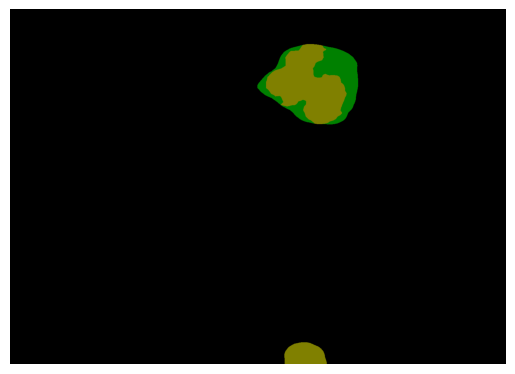

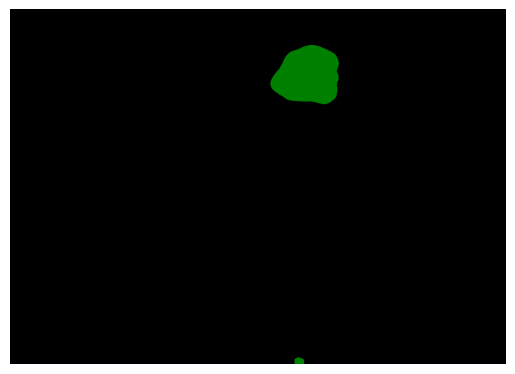

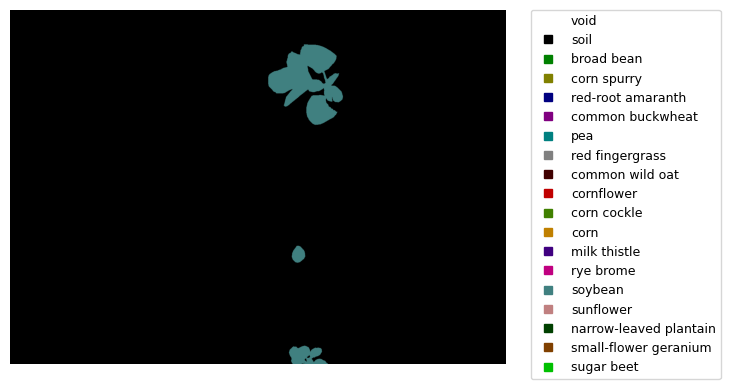

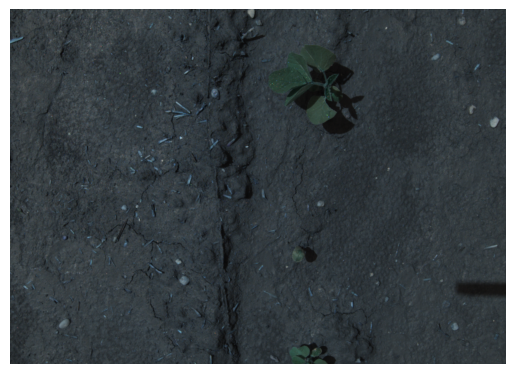

In [11]:
plot_all_info_for_image(soybean_test_ds[30], soybean_binary_model, soybean_multiclass_model)

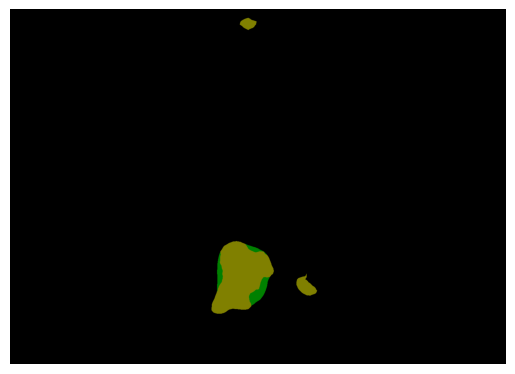

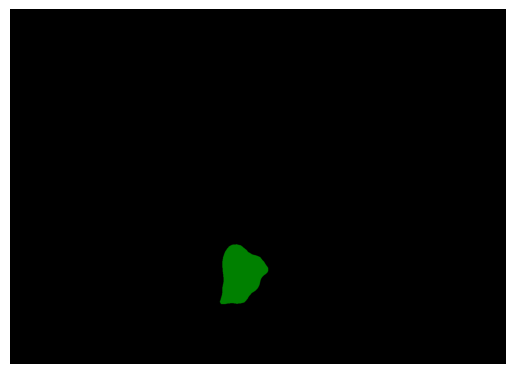

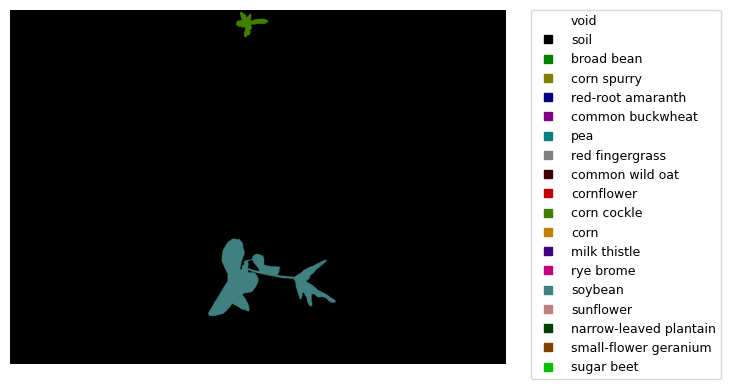

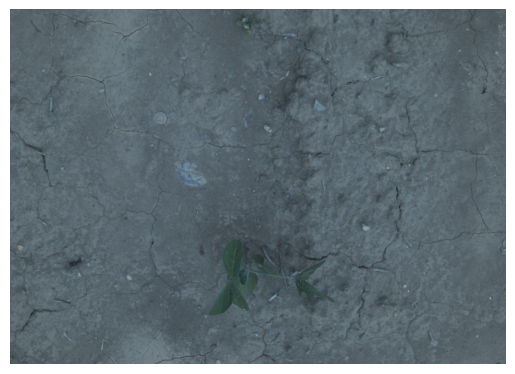

In [12]:
plot_all_info_for_image(soybean_test_ds[45], soybean_binary_model, soybean_multiclass_model)

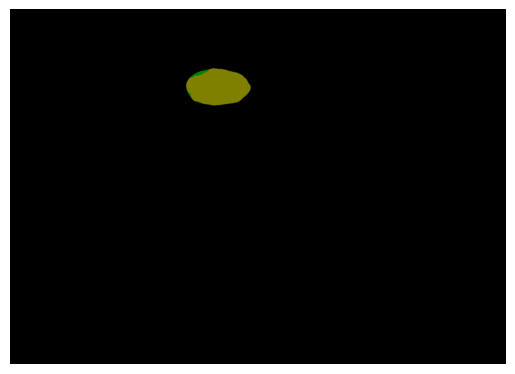

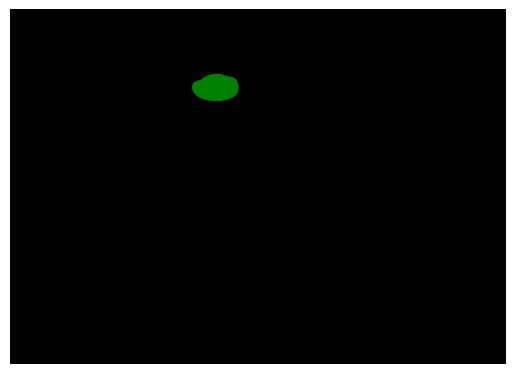

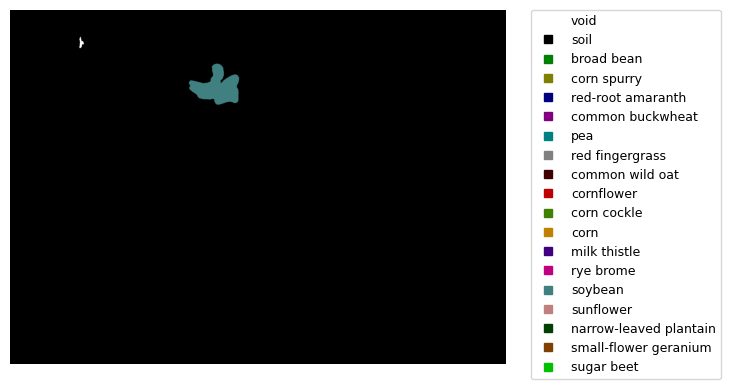

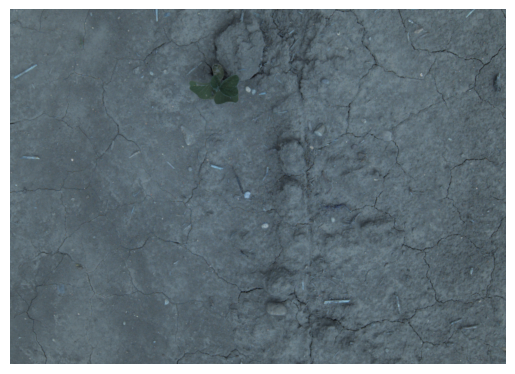

In [13]:
plot_all_info_for_image(soybean_test_ds[67], soybean_binary_model, soybean_multiclass_model)

#### Visualize predicted segmentation masks for sugar beet models

In [14]:
sugar_beet_test_ds = get_test_data('soybean', 'binary')
sugar_beet_binary_model = get_model('soybean', 'binary')
sugar_beet_multiclass_model = get_model('soybean', 'multiclass')

In [17]:
# print(len(sugar_beet_test_ds))
# for test_ds_entry in sugar_beet_test_ds:
#     plot_all_info_for_image(test_ds_entry, sugar_beet_binary_model, sugar_beet_multiclass_model)

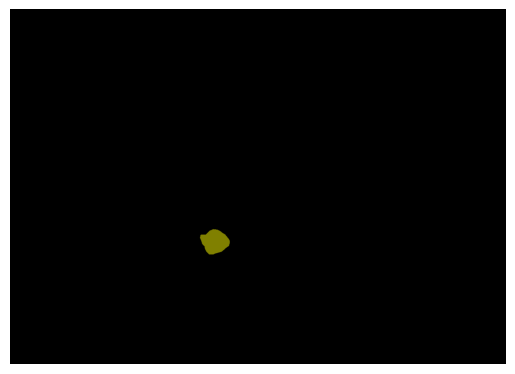

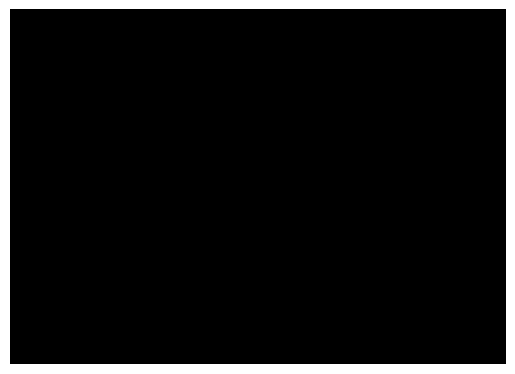

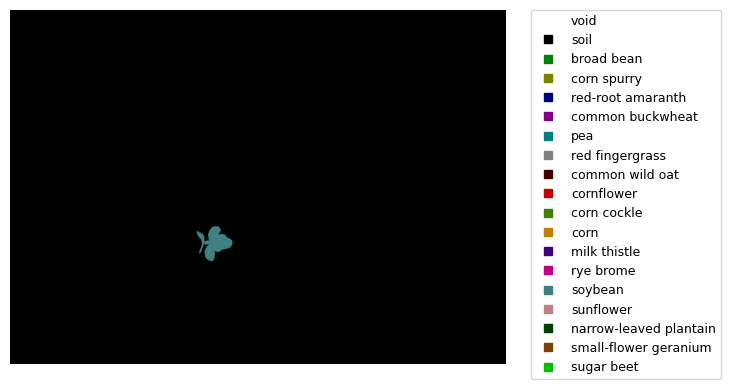

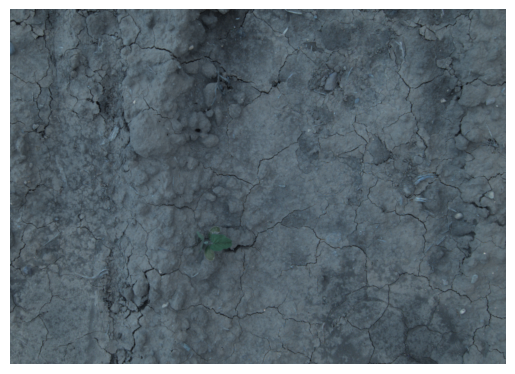

In [18]:
plot_all_info_for_image(sugar_beet_test_ds[0], sugar_beet_binary_model, sugar_beet_multiclass_model)

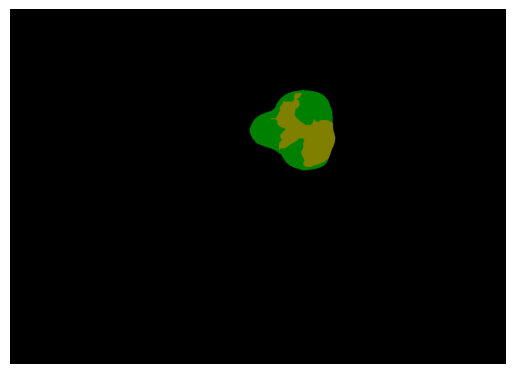

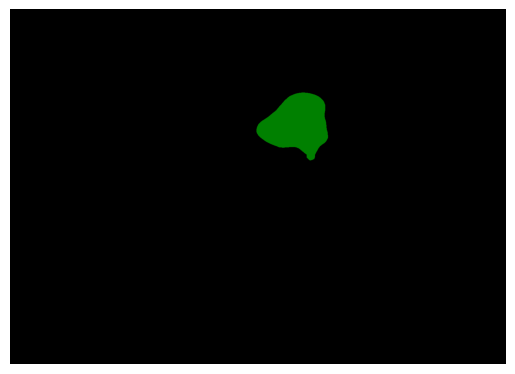

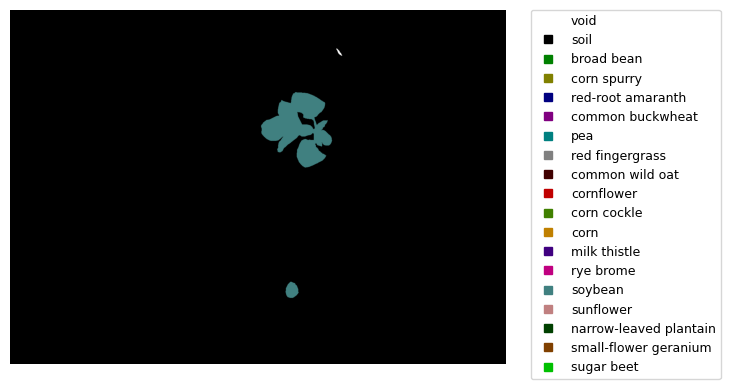

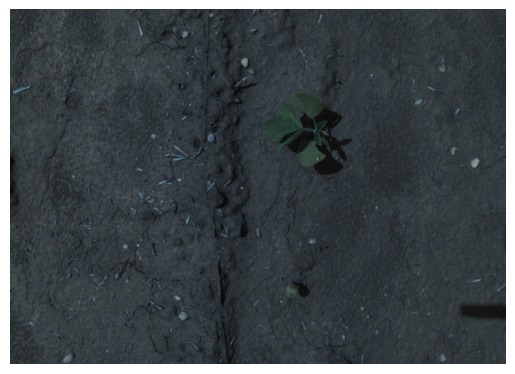

In [19]:
plot_all_info_for_image(sugar_beet_test_ds[23], sugar_beet_binary_model, sugar_beet_multiclass_model)